In [1]:
!pip install wandb
!pip install -qU bbox-utility

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 143 kB 43.9 MB/s 
     |████████████████████████████████| 180 kB 44.7 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=75b91c95aa0cb1f115b92030f363a2844a1dfac43602b5cd557c4487edd1d702
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
     |████████████████████████████████| 58 kB 1.7 MB/s 
     |████████████████████████████████| 3.3 MB 5.2 MB/s 
     |████████████████████████████████| 34.5 MB 31.1 MB/s 


In [2]:
PROJECT_PATH = '/content/drive/MyDrive/datasets/potholes_object_detection'
IMAGES_PATH = '/content/drive/MyDrive/datasets/potholes_object_detection/images'
ANNOTATIONS_PATH = '/content/drive/MyDrive/datasets/potholes_object_detection/annotations'
YOLOV5_PATH = '/content/drive/MyDrive/datasets/potholes_object_detection/yolov5'

MODEL = 'yolov5s'
DIM = 640

EPOCHS = 200
BATCH = 16
OPTMIZER = 'Adam'
PROJECT   = 'potholes_detected' # w&b in yolov5
NAME      = f'{PROJECT}-dim{DIM}' # w&b for yolov5

In [3]:
#Install Yolov5 model
#!git clone https://github.com/ultralytics/yolov5
#%cd yolov5
#%pip install -qr requirements.txt  # install

In [4]:
%cd {YOLOV5_PATH}
import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.0-218-g7539cd7 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.3/78.2 GB disk)


In [5]:
import os
import wandb
import yaml

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm
from bbox.utils import *
from sklearn.model_selection import train_test_split

tqdm.pandas()


In [6]:
!wandb login 80656862a97dbf8034a740dd697515543aa07c0a

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [7]:
image_list = [file_name for file_name in os.listdir(IMAGES_PATH)\
                if file_name[-3:] == 'png']
image_series = pd.Series(image_list)
image_series.sort_values(inplace=True)
print('Total images = ', len(image_series))
print(image_series[:4])
anotation_series = pd.Series(os.listdir(ANNOTATIONS_PATH))
anotation_series.sort_values(inplace=True)
print(anotation_series[:4])

df = pd.DataFrame({
    'image': list(image_series),
    'anotation': list(anotation_series)
    })
df['image'] = df.apply(lambda row: os.path.join(IMAGES_PATH, row['image']), axis=1)
df['anotation'] = df.apply(lambda row: os.path.join(ANNOTATIONS_PATH, row['anotation']), axis=1)

Total images =  665
141      potholes0.png
148      potholes1.png
143     potholes10.png
131    potholes100.png
dtype: object
62       potholes0.xml
364      potholes1.xml
362     potholes10.xml
35     potholes100.xml
dtype: object


In [8]:
print(df['image'].iloc[5])
print(df['anotation'].iloc[5])

/content/drive/MyDrive/datasets/potholes_object_detection/images/potholes102.png
/content/drive/MyDrive/datasets/potholes_object_detection/annotations/potholes102.xml


In [9]:
#Image size
def get_size(path):
    img = cv2.imread(path)
    height, width, channels = img.shape
    print(path)
    return [width, height]

df['size_w_h'] = df.progress_apply(lambda row: get_size(row['image']), axis=1)
max_dim = max(df['size_w_h'].max())

  0%|          | 0/665 [00:00<?, ?it/s]

/content/drive/MyDrive/datasets/potholes_object_detection/images/potholes0.png
/content/drive/MyDrive/datasets/potholes_object_detection/images/potholes1.png
/content/drive/MyDrive/datasets/potholes_object_detection/images/potholes10.png
/content/drive/MyDrive/datasets/potholes_object_detection/images/potholes100.png
/content/drive/MyDrive/datasets/potholes_object_detection/images/potholes101.png
/content/drive/MyDrive/datasets/potholes_object_detection/images/potholes102.png
/content/drive/MyDrive/datasets/potholes_object_detection/images/potholes103.png
/content/drive/MyDrive/datasets/potholes_object_detection/images/potholes104.png
/content/drive/MyDrive/datasets/potholes_object_detection/images/potholes105.png
/content/drive/MyDrive/datasets/potholes_object_detection/images/potholes106.png
/content/drive/MyDrive/datasets/potholes_object_detection/images/potholes107.png
/content/drive/MyDrive/datasets/potholes_object_detection/images/potholes108.png
/content/drive/MyDrive/datasets/p

In [10]:
df.head(3)

,image,anotation,size_w_h
0,/content/drive/MyDrive/datasets/potholes_objec...,/content/drive/MyDrive/datasets/potholes_objec...,"[450, 300]"
1,/content/drive/MyDrive/datasets/potholes_objec...,/content/drive/MyDrive/datasets/potholes_objec...,"[400, 300]"
2,/content/drive/MyDrive/datasets/potholes_objec...,/content/drive/MyDrive/datasets/potholes_objec...,"[400, 400]"


In [11]:
#parse anotations
def get_boxes(path):
    result_boxes = []
    boxes_all =[]
    tree = ET.parse(path)
    objects = tree.findall('object')
    for object_el in objects:
        boxes_all.append(object_el.findall('bndbox')[0])
    for i, box_el in enumerate(boxes_all):
        result_boxes.append([
                        box_el.find('xmin').text, 
                        box_el.find('ymin').text,
                        box_el.find('xmax').text,
                        box_el.find('ymax').text,
        ])
        
    return result_boxes

In [12]:
def convert2yolo(voc, image_size):
    # check https://github.com/awsaf49/bbox for source code of following utility functions
    """
    voc  => [x1, y1, x2, y2]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    voc = np.array(voc.copy()).astype(float)

    width = image_size[0]
    height = image_size[1]

    return voc2yolo(voc, height=height, width=width)

In [13]:
df['voc_boxes'] = df.progress_apply(lambda row: get_boxes(row['anotation']), axis=1)
df['yolo_boxes'] = df.progress_apply(
    lambda row: convert2yolo(row['voc_boxes'], row['size_w_h']), axis=1
    )

  0%|          | 0/665 [00:00<?, ?it/s]

  0%|          | 0/665 [00:00<?, ?it/s]

In [14]:
df['yolo_boxes'].head()

0    [[0.38222222222222224, 0.825, 0.13777777777777...
1    [[0.4975, 0.675, 0.975, 0.41000000000000003], ...
2    [[0.46875, 0.60125, 0.25249999999999995, 0.332...
3                       [[0.79375, 0.3, 0.3025, 0.24]]
4    [[0.37075471698113205, 0.5816666666666667, 0.1...
Name: yolo_boxes, dtype: object

/content/drive/MyDrive/datasets/potholes_object_detection/images/potholes0.png


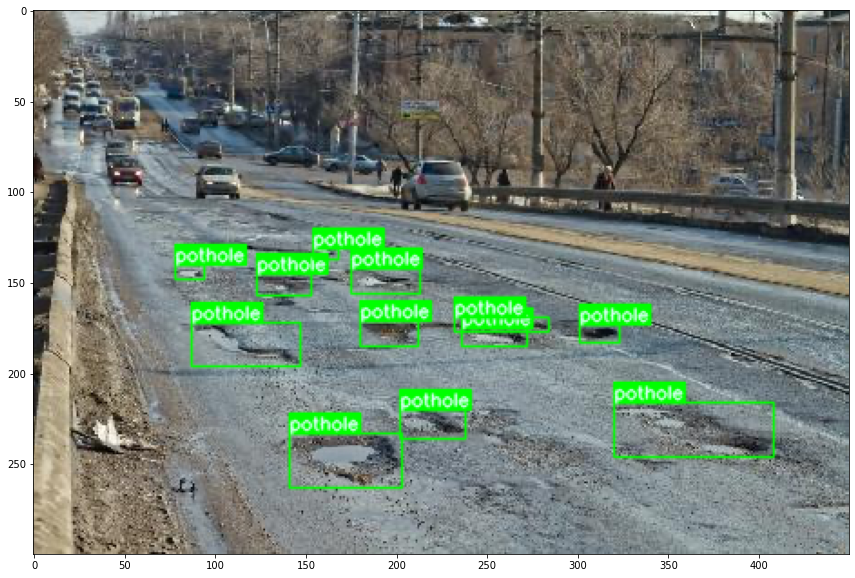

In [15]:
#draw image with boxes

plt.figure(figsize=(17,10))
row = df.iloc[0]
img = cv2.imread(row['image'])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(row['image'])

plt.imshow(draw_bboxes(
    img = img,
    bboxes = row['yolo_boxes'], 
    classes = ['pothole']*len(row['yolo_boxes']),
    class_ids = '1'*len(row['yolo_boxes']),
    class_name = True, 
    bbox_format = 'yolo',
    line_thickness = 1))
plt.show()

In [16]:
def create_label_file(path, boxes):
    with open(path, 'w') as f:
        for box in boxes:
           f.write('0 ' + ' '.join(box.astype(str))+'\n')

In [17]:
#Create labels
%cd /content/drive/MyDrive/datasets/potholes_object_detection/labels

for idx in tqdm(range(len(df))):
    row = df.iloc[idx]
    path = row['image'][:-3]+'txt'
    boxes = row['yolo_boxes']

    create_label_file(path, boxes)

df['anotation-txt-path'] = df['image'].progress_apply(lambda path: path[:-3] + 'txt')

/content/drive/MyDrive/datasets/potholes_object_detection/labels


  0%|          | 0/665 [00:00<?, ?it/s]

  0%|          | 0/665 [00:00<?, ?it/s]

In [18]:
#create label folder
#%cd /content/drive/MyDrive/datasets/potholes_object_detection
#!mkdir labels
#%cp -r /content/drive/MyDrive/datasets/potholes_object_detection/images/. /content/drive/MyDrive/datasets/potholes_object_detection/labels

In [19]:
#train test split
df_train, df_test = train_test_split(
    df[['image', 'anotation-txt-path']],
    test_size=0.15,
    random_state=42,
    shuffle=True)

In [20]:
#Create *.txt files for the train config
%cd {YOLOV5_PATH}
CONFIG_DIR = 'config_train'
CONFIG_PATH = os.path.join(YOLOV5_PATH, CONFIG_DIR)

if not os.path.exists(CONFIG_DIR): 
    !mkdir {CONFIG_DIR}
%cd config_train/

with open(os.path.join(CONFIG_PATH, 'train.txt'), 'w') as f:
    for path in df_train['image'].tolist():
        f.write(path+'\n')
            
with open(os.path.join(CONFIG_PATH, 'val.txt'), 'w') as f:
    for path in df_test['image'].tolist():
        f.write(path+'\n')

data = dict(
    path = CONFIG_PATH,
    train = os.path.join(CONFIG_PATH, 'train.txt') ,
    val = os.path.join(CONFIG_PATH, 'val.txt' ),
    nc = 1,
    names = ['pothole'],
    )

with open(os.path.join(CONFIG_PATH, 'config_train.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

HYP_CONFIG = CONFIG_PATH + '/hyp.yaml'

/content/drive/MyDrive/datasets/potholes_object_detection/yolov5
/content/drive/MyDrive/datasets/potholes_object_detection/yolov5/config_train


In [21]:
%%writefile {HYP_CONFIG}
lr0: 0.001  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.01  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.9  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 20.0  # image rotation (+/- deg)
translate: 0.10  # image translation (+/- fraction)
scale: 0.5  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.3  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 0.8  # image mosaic (probability)
mixup: 0.25 # image mixup (probability)
copy_paste: 0.0  # segment copy-paste (probability)

Overwriting /content/drive/MyDrive/datasets/potholes_object_detection/yolov5/config_train/hyp.yaml


In [22]:
#%cd {YOLOV5_PATH}
#%pip install -qr requirements.txt  # install
#!python train.py --img {DIM} \
#--batch {BATCH} \
#--epochs {EPOCHS} \
#--optimizer {OPTMIZER} \
#--data /content/drive/MyDrive/datasets/potholes_object_detection/yolov5/config_train/config_train.yaml \
#--hyp /content/drive/MyDrive/datasets/potholes_object_detection/yolov5/config_train/hyp.yaml \
#--weights {MODEL}.pt \
#--project {PROJECT} --name {NAME} \
#--save-period 20 \
#--exist-ok

In [39]:
#test from internet images
TEST_DIR = '/content/drive/MyDrive/datasets/potholes_object_detection/pothole_from_internet/'
WEIGHTS = '/content/drive/MyDrive/datasets/potholes_object_detection/yolov5/potholes_detected/potholes_detected-dim640/weights/best.pt'
count = 0
images = []
#load the model
model = torch.hub.load(
    YOLOV5_PATH,
    'custom',
    path=WEIGHTS,
    source='local')


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /content/drive/MyDrive/datasets/potholes_object_detection/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.0-218-g7539cd7 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


In [63]:
from PIL import Image

def show_img(img, bboxes, bbox_format='yolo'):
    names  = ['pothole']*len(bboxes)
    labels = [0]*len(bboxes)
    img    = draw_bboxes(img = img,
                           bboxes = bboxes, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           bbox_format = bbox_format,
                           line_thickness = 1)
    return Image.fromarray(img)

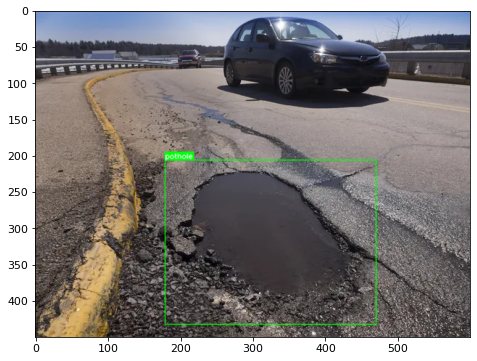

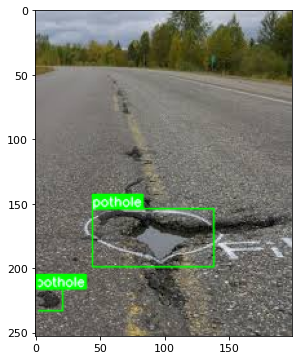

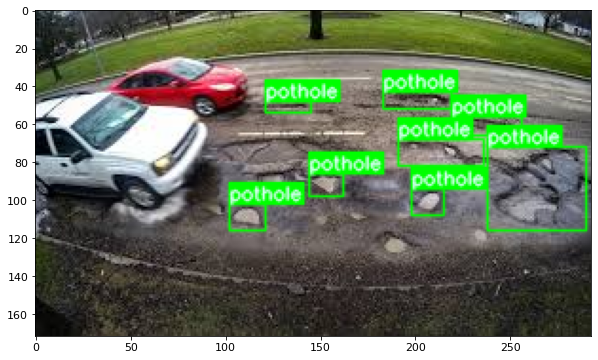

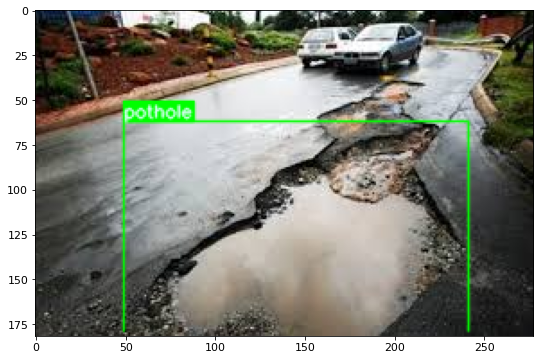

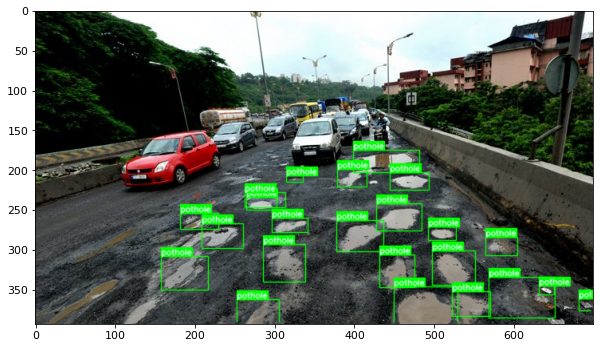

In [64]:
for img_name in os.listdir(TEST_DIR):
    img = cv2.imread(os.path.join(TEST_DIR, img_name))[:,:,::-1]
    result = model(img)
    preds = result.pandas().xyxy[0]
    bboxes  = preds[['xmin','ymin','xmax','ymax']].values
    plt.figure(figsize=(10,6))
    for img in result.imgs:
        plt.imshow(show_img(img, bboxes, bbox_format='voc'))
        plt.show()